## CSC529 Case Study 3 - Hidden Markov Model
##### Yuxuan Zhang
<p>See data explaination and instructions <a href="https://inst.eecs.berkeley.edu/~cs188/sp08/projects/hmm/project_hmm.html">here</a>.</p>

In [310]:
import numpy as np
from hmmlearn import hmm
from matplotlib import cm, pyplot as plt
%matplotlib inline
import matplotlib
import pandas as pd
from pandas import DataFrame, Series

### Read data

In [87]:
state_seq = []
observation_seq = []
f = open('weather-test1-1000.txt','r')
line = f.readline()
while line:
    line=line.rstrip().split(',')
    
    # encoding: sunny:0, rainy:1, foggy:2
    if line[0] == 'sunny':
        state_seq.append(0)
    elif line[0] == 'rainy':
        state_seq.append(1)
    else:
        state_seq.append(2)
    
    # encoding: yes:0, no:1
    if line[1] == 'yes':
        observation_seq.append(0)
    else:
        observation_seq.append(1)
    line = f.readline()

### Exploratory analysis

In [396]:
# hidden states
z_decode = {0:'sunny',1:'rainy',2:'foggy'}
z_encode = {'sunny':0,'rainy':1,'foggy':2}

# possible observations
# 'yes' for unbrella is observed
x_decode = {0:'yes',1:'no'}
x_encode = {'yes':0,'no':1}

# start probability vector for hidden states is given in the instruction
# P(sunny) = 0.5, P(rainy) = 0.25, P(foggy) = 0.25
start_prob = [0.5, 0.25, 0.25]

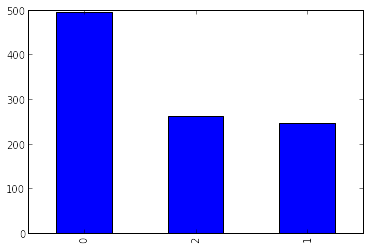

In [397]:
Series(state_seq).value_counts().plot(kind='bar')

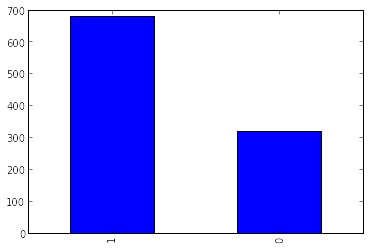

In [398]:
Series(observation_seq).value_counts().plot(kind='bar')

In [399]:
df = DataFrame({'hidden':state_seq,'observation':observation_seq})

In [400]:
df.groupby(['hidden','observation'])['observation'].count()

hidden  observation
0       0               42
        1              452
1       0              199
        1               46
2       0               79
        1              182
Name: observation, dtype: int64

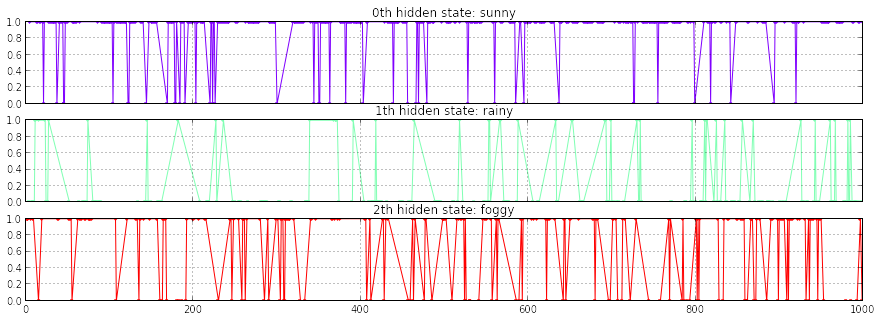

In [403]:
# x-axis: 1000 days, y-axis: with umbrella(0), without umbrella(1)
num_hidden_states = 3
fig, axs = plt.subplots(num_hidden_states, sharex=True, sharey=True,figsize=(15,5))
colours = cm.rainbow(np.linspace(0, 1, num_hidden_states))
date_range = np.array(range(1,len(state_seq)+1))
for i, (ax, colour) in enumerate(zip(axs, colours)):
    # Use fancy indexing to plot data in each state.
    mask = np.array(state_seq) == i
    ax.plot(date_range[mask], np.array(observation_seq)[mask], ".-", c=colour)
    ax.set_title("{0}th hidden state".format(i)+': '+z_decode[i])

    ax.grid(True)

plt.show()

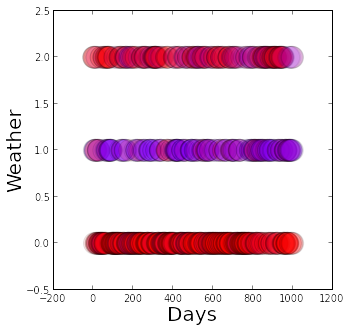

In [408]:
fig = plt.figure(figsize=(5,5)) 
fig1 = fig.add_subplot(111)
fig1.scatter(range(1,len(state_seq)+1), state_seq, s=480, c=observation_seq, alpha=0.1, cmap=plt.cm.rainbow)
fig1.set_xlabel('Days', fontsize=20)
fig1.set_ylabel('Weather', fontsize=20)

<p>Sunny:0, rainy:1, foggy:2; <br>
With umbrella: blue, without umbrella: red<br><br>
For sunny, we see most of the times there are no umbrella<br>
For rainy, we see the majority of the time ther are umbrellas<br>
For foggy, there are more days we see no umbrella than days we see there are.</p>

## 1. Construct HMM manually

#### Compute hidden state transitional probability matrix

In [33]:
# E.G. {sunny: {sunny: 11, rainy: 20, foggy: 5}}
state_occurrence_dic = {}
for i in range(1,len(state_seq)):
    if state_seq[i-1] not in state_occurrence_dic:
        state_occurrence_dic[state_seq[i-1]] = {state_seq[i]:1}
    else:
        if state_seq[i] not in state_occurrence_dic[state_seq[i-1]]:
            state_occurrence_dic[state_seq[i-1]][state_seq[i]] = 1
        else:
            state_occurrence_dic[state_seq[i-1]][state_seq[i]] += 1

In [34]:
state_occurrence_dic

{0: {0: 392, 1: 27, 2: 74},
 1: {0: 48, 1: 142, 2: 55},
 2: {0: 54, 1: 76, 2: 131}}

In [71]:
sunny = np.array(state_occurrence_dic[0].values())/float(sum(state_occurrence_dic[0].values()))
rainy = np.array(state_occurrence_dic[1].values())/float(sum(state_occurrence_dic[1].values()))
foggy = np.array(state_occurrence_dic[2].values())/float(sum(state_occurrence_dic[2].values()))
transition_matrix = np.vstack((sunny,rainy,foggy))
transition_matrix

array([[ 0.79513185,  0.05476673,  0.15010142],
       [ 0.19591837,  0.57959184,  0.2244898 ],
       [ 0.20689655,  0.29118774,  0.50191571]])

#### Compute emission probability matrix

In [88]:
# E.G. {sunny: {yes: 11, no: 20}}
ob_occurrence_dic = {}
for i in range(len(state_seq)):
    if state_seq[i] not in ob_occurrence_dic:
        ob_occurrence_dic[state_seq[i]] = {observation_seq[i]:1}
    else:
        if observation_seq[i] not in ob_occurrence_dic[state_seq[i]]:
            ob_occurrence_dic[state_seq[i]][observation_seq[i]] = 1
        else:
            ob_occurrence_dic[state_seq[i]][observation_seq[i]] += 1

In [89]:
ob_occurrence_dic

{0: {0: 42, 1: 452}, 1: {0: 199, 1: 46}, 2: {0: 79, 1: 182}}

In [92]:
sunny = np.array(ob_occurrence_dic[0].values())/float(sum(ob_occurrence_dic[0].values()))
rainy = np.array(ob_occurrence_dic[1].values())/float(sum(ob_occurrence_dic[1].values()))
foggy = np.array(ob_occurrence_dic[2].values())/float(sum(ob_occurrence_dic[2].values()))
emission_matrix = np.vstack((sunny,rainy,foggy))
emission_matrix

array([[ 0.08502024,  0.91497976],
       [ 0.8122449 ,  0.1877551 ],
       [ 0.30268199,  0.69731801]])

#### construct HMM model using the calculated parameters

In [146]:
# n_components=3 means three hidden states [0, 1, 2]
model_manual = hmm.MultinomialHMM(n_components=3)

# start probabilities for each hidden state
model_manual.startprob_ = start_prob

# transitional matrix for pair-wise hidden state
model_manual.transmat_ = transition_matrix

# emission probability matrix for [hidden state,observation]
model_manual.emissionprob_ = emission_matrix

In [444]:
# probability of the model
print 'log probability under the model: ',model_manual.score(observation_seq)
print 'probability under the model: ',np.exp(model_manual.score(observation_seq))

log probability under the model:  -591.51752839
probability under the model:  1.27997495238e-257


/Library/Python/2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Library/Python/2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


### 1.1 With the constructed HMM, find the most likely state sequence corresponding to new observation sequence given

In [409]:
#test_observation = ['no', 'no', 'no', 'yes', 'no', 'no', 'yes', 'yes', 'no', 'yes']
test_observation = ['no', 'yes', 'yes', 'no', 'yes', 'no', 'no', 'yes', 'no', 'no']
test_observation_encode = [x_encode[i] for i in test_observation]
test_observation_encode = np.atleast_2d(test_observation_encode).T
test_observation_encode

array([[1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1]])

In [410]:
log_prob, pred_sequence = model_manual.decode(test_observation_encode, algorithm="viterbi")
for i in zip(test_observation,map(lambda x:z_decode[x],pred_sequence)):
    print "Observation on Umbrella:",i[0], ", Predicted Weather:",i[1]

Observation on Umbrella: no , Predicted Weather: foggy
Observation on Umbrella: yes , Predicted Weather: rainy
Observation on Umbrella: yes , Predicted Weather: rainy
Observation on Umbrella: no , Predicted Weather: rainy
Observation on Umbrella: yes , Predicted Weather: rainy
Observation on Umbrella: no , Predicted Weather: sunny
Observation on Umbrella: no , Predicted Weather: sunny
Observation on Umbrella: yes , Predicted Weather: sunny
Observation on Umbrella: no , Predicted Weather: sunny
Observation on Umbrella: no , Predicted Weather: sunny


In [417]:
all_observation_encode = np.atleast_2d(observation_seq).T
_, pred_sequence_all = model_manual.decode(all_observation_encode, algorithm="viterbi")

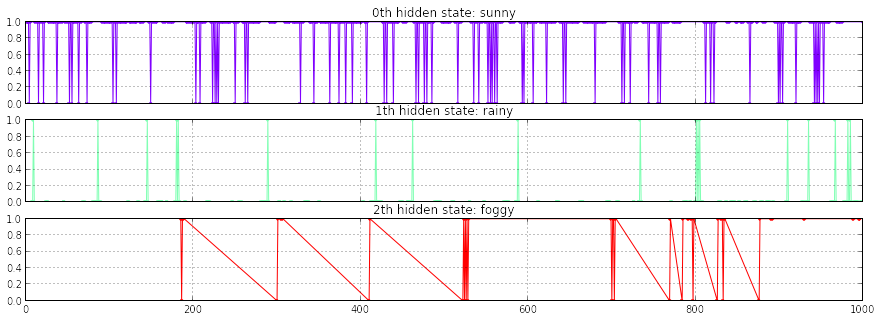

In [418]:
# x-axis: 1000 days, y-axis: with umbrella(0), without umbrella(1)
num_hidden_states = 3
fig, axs = plt.subplots(num_hidden_states, sharex=True, sharey=True,figsize=(15,5))
colours = cm.rainbow(np.linspace(0, 1, num_hidden_states))
date_range = np.array(range(1,len(state_seq)+1))
for i, (ax, colour) in enumerate(zip(axs, colours)):
    # Use fancy indexing to plot data in each state.
    mask = np.array(pred_sequence_all) == i
    ax.plot(date_range[mask], np.array(observation_seq)[mask], ".-", c=colour)
    ax.set_title("{0}th hidden state".format(i)+': '+z_decode[i])

    ax.grid(True)

plt.show()

### 1.2 Generate sample sequences for hidden states and observations

In [415]:
sample_observation, sample_hidden = model_manual.sample(10)

# decode sample observation into yes/no
sample_observation = sample_observation.reshape(10)
sample_observation = map(lambda i:x_decode[i],sample_observation)

# decode sample weather into sunny/rainy/foggy
sample_hidden = map(lambda i:z_decode[i],sample_hidden)

for i in range(10):
    print "Observation on Umbrella:",sample_observation[i], ", Weather:",sample_hidden[i]

Observation on Umbrella: yes , Weather: rainy
Observation on Umbrella: no , Weather: rainy
Observation on Umbrella: yes , Weather: rainy
Observation on Umbrella: no , Weather: foggy
Observation on Umbrella: yes , Weather: rainy
Observation on Umbrella: yes , Weather: rainy
Observation on Umbrella: yes , Weather: foggy
Observation on Umbrella: no , Weather: foggy
Observation on Umbrella: no , Weather: foggy
Observation on Umbrella: no , Weather: rainy


## 2. Construct the HMM by approximating with the observation sequence

In [420]:
# n_components=3 means three hidden states [0, 1, 2]
# n_iter = Maximum number of iterations to perform when fitting using Expectation Maximization
model_fitted = hmm.MultinomialHMM(n_components=3, n_iter=1000)

# since the EM algorithm is a gradient-based optimization method, it will generally get stuck 
#in local optima. You should in general try to run fit with various initializations and select 
# the highest scored model.
model_fitted.fit(observation_seq)

/Library/Python/2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


MultinomialHMM(algorithm='viterbi', init_params='ste', n_components=3,
        n_iter=1000, params='ste',
        random_state=<mtrand.RandomState object at 0x1120fa460>,
        startprob_prior=1.0, tol=0.01, transmat_prior=1.0, verbose=False)

In [431]:
# probability of the model fitted
print 'log probability under the model: ',model_fitted.score(observation_seq)
print 'probability under the model: ',np.exp(model_fitted.score(observation_seq))

log probability under the model:  -586.973150749
probability under the model:  1.20448003182e-255


/Library/Python/2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Library/Python/2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [430]:
print 'true transition probability matrix'
print transition_matrix,'\n'

print 'fitted transition probability matrix'
print model_fitted.transmat_

true transition probability matrix
[[ 0.79513185  0.05476673  0.15010142]
 [ 0.19591837  0.57959184  0.2244898 ]
 [ 0.20689655  0.29118774  0.50191571]] 

fitted transition probability matrix
[[ 0.64682662  0.07508687  0.27808651]
 [ 0.19651293  0.62748158  0.1760055 ]
 [ 0.55358701  0.13198485  0.31442814]]


In [432]:
print 'true emission_matrix:'
print emission_matrix ,'\n'

print 'estimated emission matrix:'
print model_fitted.emissionprob_

true emission_matrix:
[[ 0.08502024  0.91497976]
 [ 0.8122449   0.1877551 ]
 [ 0.30268199  0.69731801]] 

estimated emission matrix:
[[ 0.0733657   0.9266343 ]
 [ 0.94891389  0.05108611]
 [ 0.33668575  0.66331425]]


In [423]:
print 'fitted emission probabilities for hidden states'
print model_fitted.startprob_

fitted emission probabilities for hidden states
[  1.00000000e+00   1.15599561e-70   1.33208528e-13]


### 2. 1 With the constructed HMM, find the most likely state sequence corresponding to new observation sequence given

In [426]:
all_observation_encode = np.atleast_2d(observation_seq).T
_, pred_sequence_all = model_fitted.decode(all_observation_encode, algorithm="viterbi")

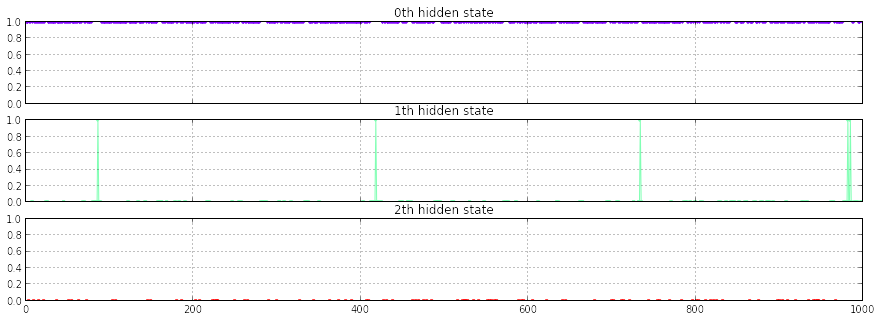

In [427]:
# x-axis: 1000 days, y-axis: with umbrella(0), without umbrella(1)
num_hidden_states = 3
fig, axs = plt.subplots(num_hidden_states, sharex=True, sharey=True,figsize=(15,5))
colours = cm.rainbow(np.linspace(0, 1, num_hidden_states))
date_range = np.array(range(1,len(state_seq)+1))
for i, (ax, colour) in enumerate(zip(axs, colours)):
    # Use fancy indexing to plot data in each state.
    mask = np.array(pred_sequence_all) == i
    ax.plot(date_range[mask], np.array(observation_seq)[mask], ".-", c=colour)
    ax.set_title("{0}th hidden state".format(i))

    ax.grid(True)

plt.show()

<p>Given the fitted HMM model, we noticed the 2th hidden state occurs only when observation = 0 (with umbrella), the 0th hidden state occurs when observation = 1 (without umbrella), and the 1th hidden state occurs mostly when observation =0 (with umbrella).<br><br>
Therefore, I would label 2th hidden state as "rainy", 0th hidden state as "sunny", and 1th hidden state as "foggy".</p>

In [434]:
z_decode_fitted = z_decode = {0:'sunny',2:'rainy',1:'foggy'}

In [439]:
#test_observation = ['no', 'no', 'no', 'yes', 'no', 'no', 'yes', 'yes', 'no', 'yes']
test_observation = ['no', 'yes', 'yes', 'no', 'yes', 'no', 'no', 'yes', 'no', 'no']
test_observation_encode = [x_encode[i] for i in test_observation]
test_observation_encode = np.atleast_2d(test_observation_encode).T
test_observation_encode

array([[1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1]])

In [440]:
log_prob, pred_sequence = model_manual.decode(test_observation_encode, algorithm="viterbi")
for i in zip(test_observation,map(lambda x:z_decode_fitted[x],pred_sequence)):
    print "Observation on Umbrella:",i[0], ", Predicted Weather:",i[1]

Observation on Umbrella: no , Predicted Weather: rainy
Observation on Umbrella: yes , Predicted Weather: foggy
Observation on Umbrella: yes , Predicted Weather: foggy
Observation on Umbrella: no , Predicted Weather: foggy
Observation on Umbrella: yes , Predicted Weather: foggy
Observation on Umbrella: no , Predicted Weather: sunny
Observation on Umbrella: no , Predicted Weather: sunny
Observation on Umbrella: yes , Predicted Weather: sunny
Observation on Umbrella: no , Predicted Weather: sunny
Observation on Umbrella: no , Predicted Weather: sunny


<p>Compared with the hidden state sequence inferrence from the manually constructed HMM, the one from the fitted HMM is very similar. They tend to disagree on "rainy" and "foggy", but consistently agree on "sunny". Since there's probability involved and HMM is an unsupervised method, there's really no correct answer on the inferrence.</p>

### 2.2 Generate sample sequences for hidden states and observations

In [443]:
sample_observation, sample_hidden = model_fitted.sample(10)

# decode sample observation into yes/no
sample_observation = sample_observation.reshape(10)
sample_observation = map(lambda i:x_decode[i],sample_observation)

# decode sample weather into sunny/rainy/foggy
sample_hidden = map(lambda i:z_decode_fitted[i],sample_hidden)

for i in range(10):
    print "Observation on Umbrella:",sample_observation[i], ", Weather:",sample_hidden[i]

Observation on Umbrella: no , Weather: sunny
Observation on Umbrella: no , Weather: sunny
Observation on Umbrella: yes , Weather: rainy
Observation on Umbrella: no , Weather: sunny
Observation on Umbrella: yes , Weather: foggy
Observation on Umbrella: yes , Weather: foggy
Observation on Umbrella: yes , Weather: foggy
Observation on Umbrella: yes , Weather: rainy
Observation on Umbrella: no , Weather: sunny
Observation on Umbrella: yes , Weather: rainy
